### Amazon Cookbooks Topic Modeling Using Descriptions

### Necessary Tools

In [14]:
import numpy as np
import pandas as pd
import re, string

#import contractions
from nltk.tokenize import word_tokenize, MWETokenizer
from nltk.chunk import ne_chunk
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer

from langdetect import detect
from textblob import TextBlob

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, LatentDirichletAllocation, TruncatedSVD, NMF
from sklearn.cluster import KMeans

from joblib import dump, load
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
%matplotlib inline


# --- Stopwords
PRINTABLE = [i for i in string.printable]
GENREIC = ["ain't", "aren't", "can't", "can't've", "'cause", "could've", "couldn't", "couldn't've", "didn't", "doesn't", "don't", "hadn't", "hadn't've", "hasn't", "haven't", "he'd", "he'd've", "he'll", "he'll've", "he's", "how'd", "how'd'y", "how'll", "how's", "i'd", "i'd've", "i'll", "i'll've", "i'm", "i've", "isn't", "it'd", "it'd've", "it'll", "it'll've", "it's", "let's", "ma'am", "mayn't", "might've", "mightn't", "mightn't've", "must've", "mustn't", "mustn't've", "needn't", "needn't've", "o'clock", "oughtn't", "oughtn't've", "shan't", "sha'n't", "shan't've", "she'd", "she'd've", "she'll", "she'll've", "she's", "should've", "shouldn't", "shouldn't've", "so've", "so's", "that'd", "that'd've", "that's", "there'd", "there'd've", "there's", "they'd", "they'd've", "they'll", "they'll've", "they're", "they've", "to've", "wasn't", "we'd", "we'd've", "we'll", "we'll've", "we're", "we've", "weren't", "what'll", "what'll've", "what're", "what's", "what've", "when's", "when've", "where'd", "where's", "where've", "who'll", "who'll've", "who's", "who've", "why's", "why've", "will've", "won't", "won't've", "would've", "wouldn't", "wouldn't've", "y'all", "y'all'd", "y'all'd've", "y'all're", "y'all've", "you'd", "you'd've", "you'll", "you'll've", "you're", "you've", "a", "about", "above", "above", "across", "after", "afterwards", "again", "against", "all", "almost", "alone", "along", "already", "also","although","always","am","among", "amongst", "amoungst", "amount",  "an", "and", "another", "any","anyhow","anyone","anything","anyway", "anywhere", "are", "around", "as",  "at", "back","be","became", "because","become","becomes", "becoming", "been", "before", "beforehand", "behind", "being", "below", "beside", "besides", "between", "beyond", "bill", "both", "bottom","but", "by", "call", "can", "cannot", "cant", "co", "con", "could", "couldnt", "cry", "de", "describe", "detail", "do", "done", "down", "due", "during", "each", "eg", "eight", "either", "eleven","else", "elsewhere", "empty", "enough", "etc", "even", "ever", "every", "everyone", "everything", "everywhere", "except", "few", "fifteen", "fify", "fill", "find", "fire", "first", "five", "for", "former", "formerly", "forty", "found", "four", "from", "front", "full", "further", "get", "give", "go", "had", "has", "hasnt", "have", "he", "hence", "her", "here", "hereafter", "hereby", "herein", "hereupon", "hers", "herself", "him", "himself", "his", "how", "however", "hundred", "ie", "if", "in", "inc", "indeed", "interest", "into", "is", "it", "its", "itself", "keep", "last", "latter", "latterly", "least", "less", "ltd", "made", "many", "may", "me", "meanwhile", "might", "mill", "mine", "more", "moreover", "most", "mostly", "move", "much", "must", "my", "myself", "name", "namely", "neither", "never", "nevertheless", "next", "nine", "no", "nobody", "none", "noone", "nor", "not", "nothing", "now", "nowhere", "of", "off", "often", "on", "once", "one", "only", "onto", "or", "other", "others", "otherwise", "our", "ours", "ourselves", "out", "over", "own","part", "per", "perhaps", "please", "put", "rather", "re", "same", "see", "seem", "seemed", "seeming", "seems", "serious", "several", "she", "should", "show", "side", "since", "sincere", "six", "sixty", "so", "some", "somehow", "someone", "something", "sometime", "sometimes", "somewhere", "still", "such", "system", "take", "ten", "than", "that", "the", "their", "them", "themselves", "then", "thence", "there", "thereafter", "thereby", "therefore", "therein", "thereupon", "these", "they", "thick", "thin", "third", "this", "those", "though", "three", "through", "throughout", "thru", "thus", "to", "together", "too", "top", "toward", "towards", "twelve", "twenty", "two", "un", "under", "until", "up", "upon", "us", "very", "via", "was", "we", "well", "were", "what", "whatever", "when", "whence", "whenever", "where", "whereafter", "whereas", "whereby", "wherein", "whereupon", "wherever", "whether", "which", "while", "whither", "who", "whoever", "whole", "whom", "whose", "why", "will", "with", "within", "without", "would", "yet", "you", "your", "yours", "yourself", "yourselves", "the"]
SUBJECT_RELATED = ['cookbook', 'cookbooks', 'book', 'books', 'recipes', 'like', 'copyright', 'information']
MISC_STOPWORDS = ['com', 'xa']
ADD_STOPWORDS = ["'caus", "'d", "'ll", "'m", "'re", "'s", "'ve", 'abov', 'afterward', 'ai', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'ca', 'cri', 'describ', 'did', 'doe', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifi', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'inform', 'latterli', 'let', 'mani', 'meanwhil', 'moreov', 'mostli', "n't", 'need', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ought', 'ourselv', 'perhap', 'pleas', 'recip', 'seriou', 'sever', 'sha', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'wo', 'yourselv']
COOKBOOK_STOPWORDS = PRINTABLE + GENREIC + SUBJECT_RELATED + MISC_STOPWORDS + ADD_STOPWORDS

VECTORIZATION = {
    'count': CountVectorizer,
    'tfidf': TfidfVectorizer
}

DIMENSIONALITY_REDUCTION = {
    'PCA': PCA,
    'LSA': TruncatedSVD,
    'NMF': NMF,
    'LDA': LatentDirichletAllocation
}

CLUSTERING = {
    'kmeans': KMeans
}

##########################################################################
# --- Helper Classes
class nlp_model:
    """
    
    #--- Parameters and thier defaults if applicable:
    vect_method = "count"
    dim_reduc="LSA"
    clustering="kmeans"
    n_components = 21
    n_clusters=6
                           
    #--- Attributes:
    self.dataNLP
    self.methods = A dictionary of strings representing pipeline of methods used for NLP model
        example: self.methods is {'Vectorization': 'count',
                                  'Dimensionality Reduction': 'LSA',
                                  'Clustering': 'kmeans'
                                  }                             
    self.objects = A dictionary of objects representing instances of methods used for NLP model
        created as part of the model fit self.fit() method
    self.outputs = A dictionary of primary outputs of pipeline used for NLP model
        created as part of the model fit self.fit() method
    self.n_components = number of components for dimensionality reduction
    self.n_clusters = number of clusters for clustering algorithm (might change with other
                      clustering algorithm inclusions in the future)
    
    #--- Methods:
    
    """
    
    def __init__(self, vect_method = "count", dim_reduc="LSA", clustering="kmeans",
                 n_components = 21, n_clusters=6):
        """
        """
        #self.doc_text = data
        
        ##########################################################################
        #--- Create self.methods attribute from the class parameters
        self.methods = {}
        
        # --- Token Vectorization Methods
        if vect_method == "tfidf":
            self.methods['Vectorization'] = vect_method
        else:
            self.methods['Vectorization'] = "count"
            
        # --- Dimensionality Reduction Methods
        if dim_reduc == "PCA" or dim_reduc == "NMF" or dim_reduc == "LDA":
            self.methods['Dimensionality Reduction'] = dim_reduc
        else:
            self.methods['Dimensionality Reduction'] = "LSA"
        
        # --- Clustering Methods (Only kmeans at the moment. Expand based on need)
        if clustering == "kmeans":
            self.methods['Clustering'] = clustering
        else:
            self.methods['Clustering'] = "kmeans"
        
        ##########################################################################
        # --- number of components for dimensionality reduction
        self.n_components = n_components
        
        # --- number of clusters for clustering
        self.n_clusters = n_clusters
        
    def fit(self, data, save_fit = False, filename = None):
        """
        Function to fit the model using the data from the arguments
        Runs through the pipeline as defined in the object instantiation
        
        Argutments:
        data - nlp data in docs X 1 format, and should be readable by vectorization method
        
        Returns: None object
        """
        ##########################################################################
        # --- Get temp methods, once instantiated will be saved under self.objects
        to_vect = VECTORIZATION[self.methods['Vectorization']]
        to_dim_reduce = DIMENSIONALITY_REDUCTION[self.methods['Dimensionality Reduction']]
        to_cluster = CLUSTERING[self.methods['Clustering']]
        
        ##########################################################################
        self.dataNLP = data
        
        self.objects = {}
        self.outputs = {}
        
        #--- Vectorization step
        self.objects['Vectorization'] =  to_vect(stop_words=COOKBOOK_STOPWORDS, tokenizer=textblob_tokenizer)
        vect_data = self.objects['Vectorization'].fit_transform(self.dataNLP)
        self.outputs['Vectorization'] = vect_data.toarray()
        
        #--- Dimensionality Reduction step
        self.objects['Dimensionality Reduction'] = to_dim_reduce(n_components=self.n_components)
        self.outputs['Dimensionality Reduction'] = self.objects['Dimensionality Reduction'].fit_transform(self.outputs['Vectorization'])
        
        #--- Clustering step
        self.objects['Clustering'] = to_cluster(n_clusters=self.n_clusters, random_state=30)
        self.objects['Clustering'].fit(self.outputs['Dimensionality Reduction'])
        self.outputs['Clustering'] = self.objects['Clustering'].labels_
        
        if save_fit and filename:
            dump(self, filename)
        
        
##########################################################################
# --- Helper Functions

# Use TextBlob
# credit: http://jonathansoma.com/lede/algorithms-2017/classes/more-text-analysis/counting-and-stemming/
def textblob_tokenizer(str_input):
    blob = TextBlob(str_input.lower())
    tokens = blob.words
    words = [token.stem() for token in tokens]
    return words

# --- To plot n-dimensional data 
def plot_all_dimensions(data, class_labels, title=""):
    
    plt.rcParams['figure.figsize'] = [30, 20]
    
    dims = data.shape[1]
    assert dims <= 6
    
    count = 1
    for dim in range(dims):
        i = dim
        j = (i+1) * int(dim != dims-1)
        
        plt.subplot(2,3, count)
        plt.scatter(data[:,i], data[:,j],# ckbk_space[vect][dr][:,2],
                   s = 4, alpha = 0.5, c=class_labels)
        plt.title(title, fontsize=20, color='red')
        count += 1
    plt.show()
    
    
# --- Parser for reading in the Amazon json files (can be used for both reviews and metadata)
# --- credits folloing parse() method to Julian McAuley UCSD: http://jmcauley.ucsd.edu/data/amazon/ 
def parse(path):
    g = open(path, 'r')
    for l in g:
        yield json.loads(l)
        

In [22]:
# --- To plot n-dimensional data 
def plot_all_dimensions3D(data, class_labels, titles=""):
    
    plt.rcParams['figure.figsize'] = [30, 20]
    fig = plt.figure()
    
    dims = data.shape[1]
    assert dims <= 6
    
    count = 1
    for dim in range(dims):
        i = dim
        j = (i+1) * int(dim != dims-1)
        k = (j+1) * int(j != dims-1)
        
        ax = fig.add_subplot(2,3, count, projection='3d')
        ax.scatter(data[:,i], data[:,j], data[:,k],
                   s = 4, alpha = 0.5, c=class_labels)
        ax.set_title(titles, fontsize=20, color='red')
        ax.grid(False)
        count += 1
    plt.show()
    

In [2]:
# --- Read cookbooks tables:  Products from meta_cookbooks.json and reviews from Cookbooks.json
ckbk_meta_file = "../data/amzn/meta_Cookbooks.json"
ckbk_reviews_file = "../data/amzn/Cookbooks.json"

ckbks = pd.read_json(ckbk_meta_file, lines=True)
print(ckbks.columns)
ckbks.drop(['also_buy', 'also_buy', 'brand', 'rank', 'also_view', 'main_cat', 'price', 'image', 'feature', 'date',
       'similar_item', 'details'], axis=1, inplace=True)
ckbks

Index(['category', 'description', 'title', 'also_buy', 'brand', 'rank',
       'also_view', 'main_cat', 'price', 'asin', 'image', 'feature', 'date',
       'similar_item', 'details'],
      dtype='object')


category  \
0      [Books, Cookbooks, Food & Wine, Regional & Int...   
1      [Books, Cookbooks, Food & Wine, Regional & Int...   
2      [Books, Cookbooks, Food & Wine, Regional & Int...   
3      [Books, Cookbooks, Food & Wine, Regional & Int...   
4      [Books, Cookbooks, Food & Wine, Regional & Int...   
...                                                  ...   
44831      [Books, Cookbooks, Food & Wine, Special Diet]   
44832  [Books, Cookbooks, Food & Wine, Beverages & Wine]   
44833                    [Books, Cookbooks, Food & Wine]   
44834                    [Books, Cookbooks, Food & Wine]   
44835                    [Books, Cookbooks, Food & Wine]   

                                             description  \
0      [Though at first glance too luscious for the p...   
1      [Lorenza de Medici has published more than 30 ...   
2      [Two collections of California's best. The lat...   
3      [Fifth in the series that includes the best-se...   
4      [The latest addition to this popular series is...   
...                                                  ...   
44831  [Recipe Excerpts from The Joy Fit Club      Ch...   
44832  ["A fascinating look at the place and function...   
44833  [ALL NEW 5th Edition to kick off 2017 with exp...   
44834  [Grit Country Series Magazine 2016  (Volume 10...   
44835  [The Whole Planet Foundation cookbook was insp...   

                                                   title        asin  
0      France: The Beautiful Cookbook- Authentic Reci...  0002154129  
1      Italy, The Beautiful Cookbook: Authentic Recip...  0002154463  
2      California, The Beautiful Cookbook: Authentic ...  0002159317  
3                        America: The Beautiful Cookbook  000215854X  
4      Mexico The Beautiful Cookbook: Authentic Recip...  000215949X  
...                                                  ...         ...  
44831    Joy Fit Club: Cookbook, Diet Plan & Inspiration  B01FMW2MZ6  
44832            Drinking in America: Our Secret History  B01FMVXYF4  
44833  Entertaining with Vegetables: A Recipe Collect...  B01FUPYP0A  
44834      Grit Guide to Cast Iron Cooking Magazine 2016  B01FV1VJ66  
44835  Liberation Soup and Other Recipes from Microen...  B01GDAS296  

[44836 rows x 4 columns]

In [3]:
#######################################################################################
# --- Cleaning and tokenizing titles and descriptions
alphanumeric = lambda x: re.sub('[\d]+', ' ', x)
punc_lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x.lower())

# --- Lowercase/remove numbers & punctuations/remove stop-words
ckbks['desc_clean'] = ckbks['description'].apply(lambda x: " ".join(str(x).strip().split()))
ckbks['desc_clean'] = ckbks['desc_clean'].map(punc_lower)
ckbks['desc_clean'] = ckbks['desc_clean'].map(alphanumeric)
ckbks['desc_count'] = ckbks['desc_clean'].apply(lambda x: len(list(x.strip().split())))
#ckbks['desc_clean'] = ckbks['desc_clean'].map(alphanumeric) 
#<==== No need to remove stopwords as this step is done in the sklearn token vectorization step

ckbks['title_clean'] = ckbks['title'].apply(lambda x: " ".join(str(x).strip().split()))
ckbks['title_clean'] = ckbks['title_clean'].map(punc_lower)
ckbks['title_clean'] = ckbks['title_clean'].map(alphanumeric)
ckbks['title_count'] = ckbks['title_clean'].apply(lambda x: len(list(x.strip().split())))
#ckbks['desc_clean'] = ckbks['desc_clean'].map(alphanumeric) 
#<==== No need to remove stopwords as this step is done in the sklearn token vectorization step

#ckbks['lang']=ckbks['description'].apply(lambda x: detect(x) if (len(" ".join(str(x).strip().split())) > 5) else "NKnown")

data = ckbks[["asin", "title", "title_clean", "title_count", "description", "desc_clean", "desc_count"]].copy()
data['title_ok']=data['title_count'].apply(lambda x: 1 if (x < 50) else 0)
data['desc_ok']=data['desc_count'].apply(lambda x: 1 if (x>=5 and x < 5000) else 0)
data['use_these']=data['desc_ok']*data['title_ok']
#data
#data[data['title_count']>50]
#indx_to_drop = data[data['title_count']>50].index
#data.drop(indx_to_drop, inplace=True)
#data[data['desc_count']>5000]#.value_counts(bins=10)
data[data['use_these']==1]

asin                                              title  \
0      0002154129  France: The Beautiful Cookbook- Authentic Reci...   
1      0002154463  Italy, The Beautiful Cookbook: Authentic Recip...   
2      0002159317  California, The Beautiful Cookbook: Authentic ...   
3      000215854X                    America: The Beautiful Cookbook   
4      000215949X  Mexico The Beautiful Cookbook: Authentic Recip...   
...           ...                                                ...   
44831  B01FMW2MZ6    Joy Fit Club: Cookbook, Diet Plan & Inspiration   
44832  B01FMVXYF4            Drinking in America: Our Secret History   
44833  B01FUPYP0A  Entertaining with Vegetables: A Recipe Collect...   
44834  B01FV1VJ66      Grit Guide to Cast Iron Cooking Magazine 2016   
44835  B01GDAS296  Liberation Soup and Other Recipes from Microen...   

                                             title_clean  title_count  \
0      france  the beautiful cookbook  authentic reci...           11   
1      italy  the beautiful cookbook  authentic recip...           11   
2      california  the beautiful cookbook  authentic ...            8   
3                        america  the beautiful cookbook            4   
4      mexico the beautiful cookbook  authentic recip...           11   
...                                                  ...          ...   
44831    joy fit club  cookbook  diet plan   inspiration            7   
44832            drinking in america  our secret history            6   
44833  entertaining with vegetables  a recipe collect...           17   
44834         grit guide to cast iron cooking magazine              7   
44835  liberation soup and other recipes from microen...           10   

                                             description  \
0      [Though at first glance too luscious for the p...   
1      [Lorenza de Medici has published more than 30 ...   
2      [Two collections of California's best. The lat...   
3      [Fifth in the series that includes the best-se...   
4      [The latest addition to this popular series is...   
...                                                  ...   
44831  [Recipe Excerpts from The Joy Fit Club      Ch...   
44832  ["A fascinating look at the place and function...   
44833  [ALL NEW 5th Edition to kick off 2017 with exp...   
44834  [Grit Country Series Magazine 2016  (Volume 10...   
44835  [The Whole Planet Foundation cookbook was insp...   

                                              desc_clean  desc_count  \
0        though at first glance too luscious for the ...         258   
1        lorenza de medici has published more than   ...         520   
2        two collections of california  s best  the l...         165   
3        fifth in the series that includes the best s...          92   
4        the latest addition to this popular series i...         167   
...                                                  ...         ...   
44831    recipe excerpts from the joy fit club chicke...         362   
44832     a fascinating look at the place and functio...         556   
44833    all new  th edition to kick off   with expan...          94   
44834    grit country series magazine    volume    no...          70   
44835    the whole planet foundation cookbook was ins...          74   

       title_ok  desc_ok  use_these  
0             1        1          1  
1             1        1          1  
2             1        1          1  
3             1        1          1  
4             1        1          1  
...         ...      ...        ...  
44831         1        1          1  
44832         1        1          1  
44833         1        1          1  
44834         1        1          1  
44835         1        1          1  

[29929 rows x 10 columns]

In [4]:
dataTitles=data[data['use_these']==1]['title_clean'].copy()
ckbks_model = nlp_model(vect_method = "tfidf", dim_reduc="LSA", n_components = 10, n_clusters = 10)
ckbks_model.fit(dataTitles, save_fit = True, filename = "../model/LSA_titles_textblob.joblib")
#dr_data_desc = model.doc_dr_data

//anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'cau", 'anywh', 'becau', 'el', 'elsewh', 'everywh', 'ind', 'otherwi', 'plea', 'somewh'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


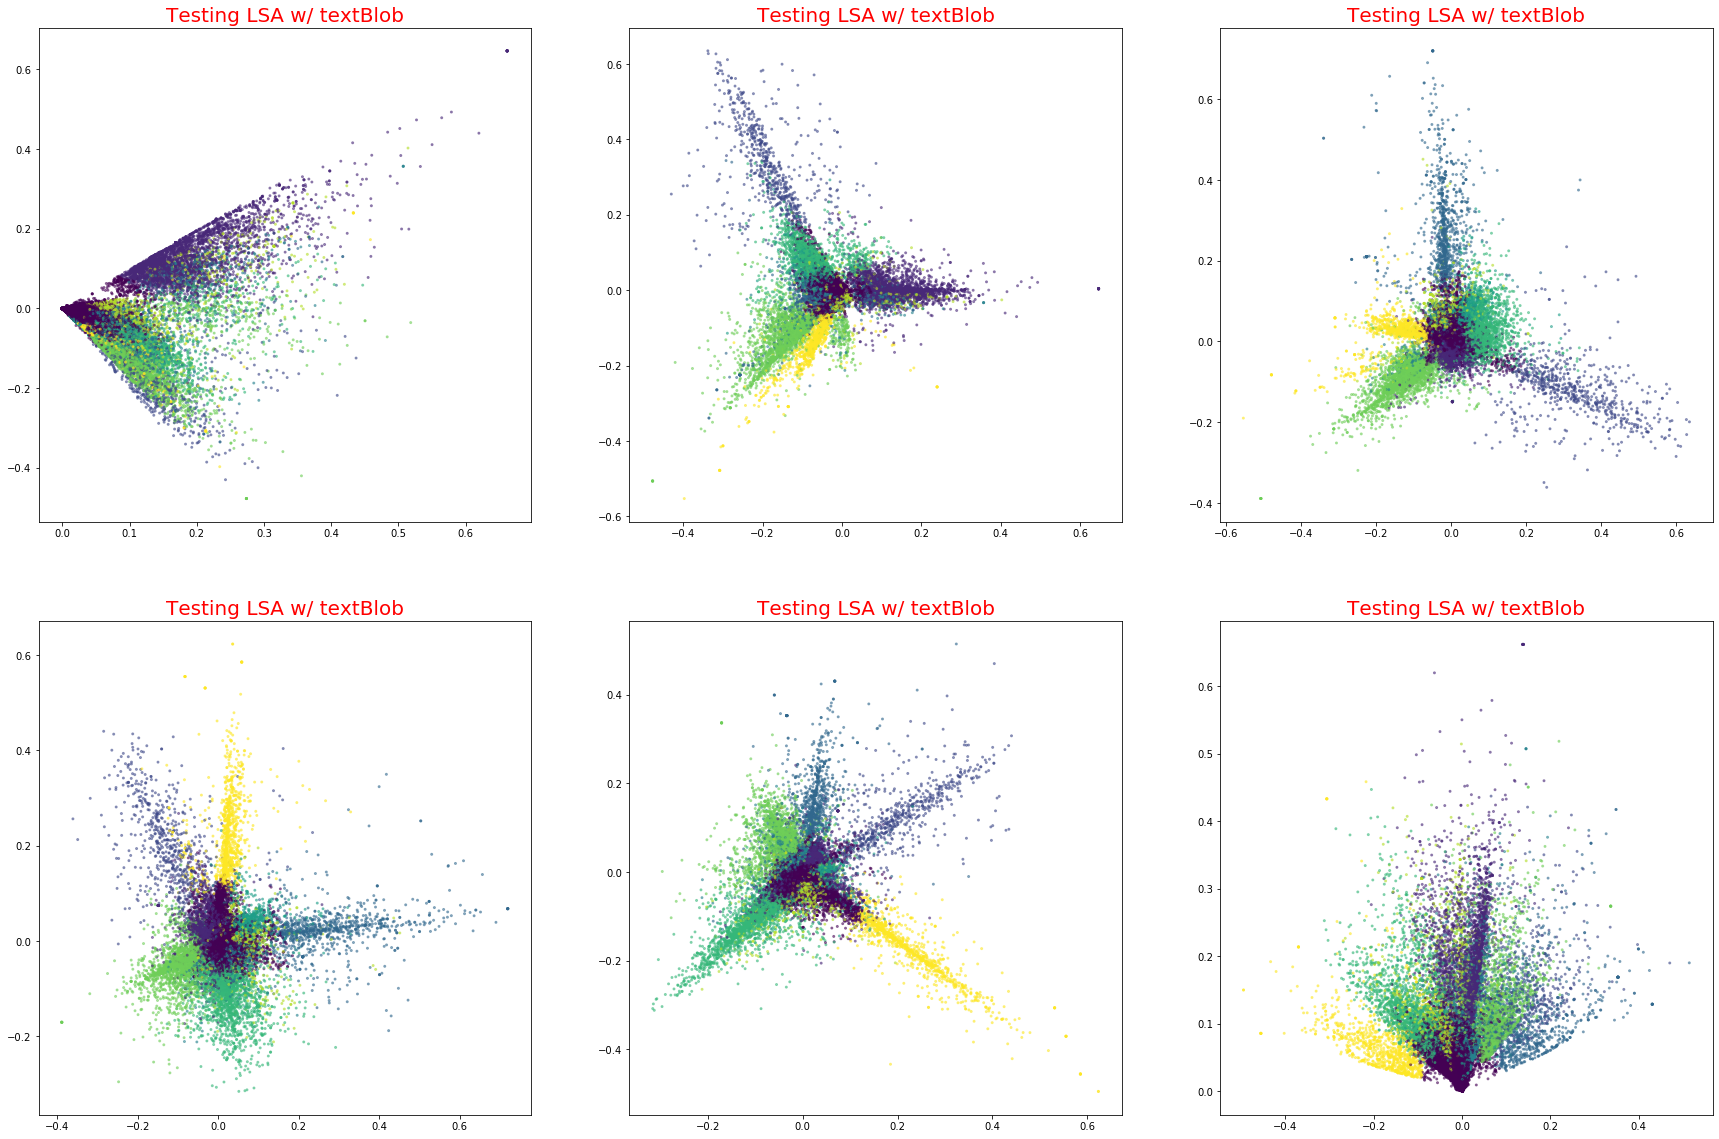

In [5]:
data_dr_lsa = ckbks_model.outputs['Dimensionality Reduction']
labels_lsa = ckbks_model.outputs['Clustering']
plot_all_dimensions(data_dr_lsa[:,:6], labels_lsa, title="Testing LSA w/ textBlob")

In [6]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

lsa_model = ckbks_model.objects['Dimensionality Reduction']
vect_words = ckbks_model.objects['Vectorization'].get_feature_names()
        
display_topics(lsa_model, vect_words, 30, topic_names=None)


Topic  0
cook, food, home, easi, kitchen, healthi, delici, guid, best, free, meal, famili, vegetarian, new, eat, simpl, favorit, italian, wine, gluten, quick, great, world, tast, classic, vegan, make, american, slow, good

Topic  1
cook, home, chines, italian, indian, japanes, countri, light, art, garden, french, mexican, annual, crocker, school, betti, microwav, illustr, techniqu, greek, polish, sunset, joy, class, today, way, fine, dutch, style, herb

Topic  2
free, gluten, delici, easi, meal, healthi, bake, cooker, dairi, vegan, slow, low, dessert, quick, fat, diet, cake, sugar, paleo, wheat, cooki, grain, bread, sweet, carb, vegetarian, minut, everyday, dish, treat

Topic  3
best, favorit, home, bake, cake, cooker, cooki, tast, collect, kitchen, america, slow, bread, new, dessert, classic, soup, wine, easi, make, countri, dish, pie, christma, restaur, sweet, chef, world, meal, year

Topic  4
wine, free, guid, gluten, bake, complet, cook, best, countri, dairi, world, cake, cooki, l

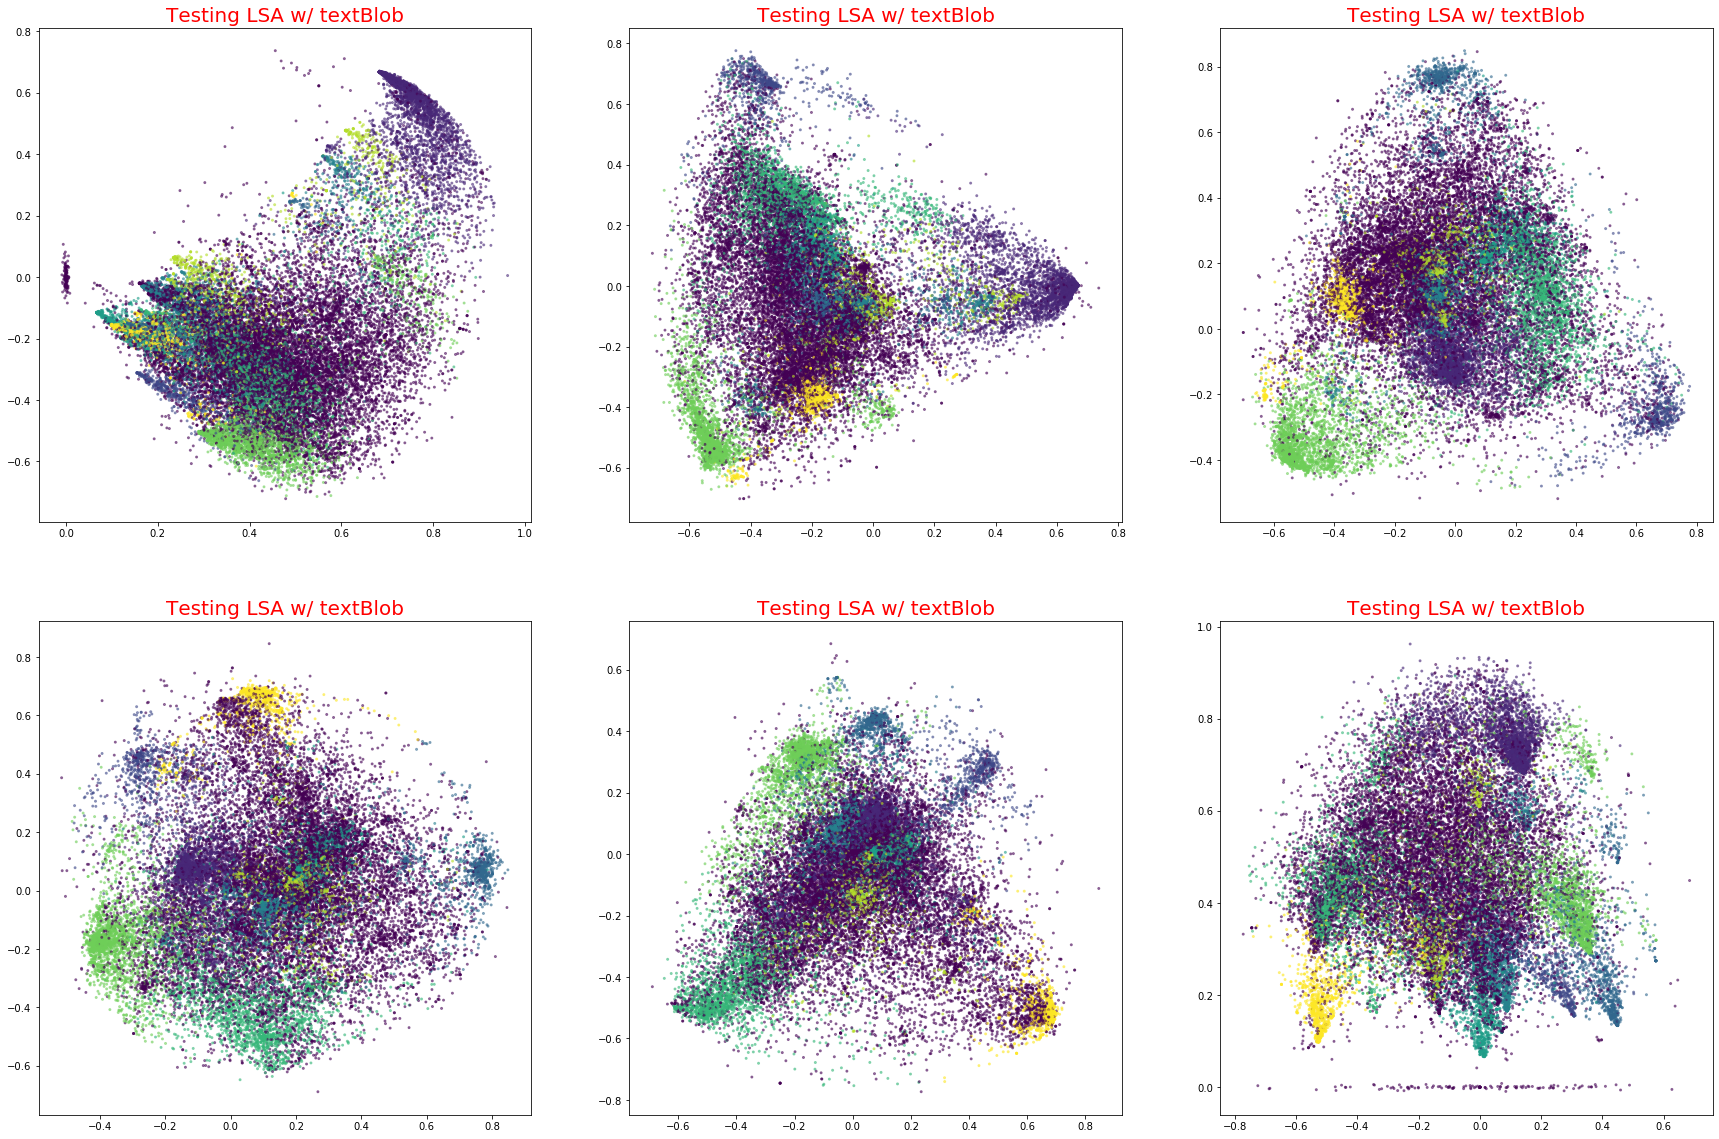

In [7]:
from sklearn.preprocessing import normalize

data_norm = normalize(data_dr_lsa)
plot_all_dimensions(data_norm[:,:6], labels_lsa, title="Testing LSA w/ textBlob")

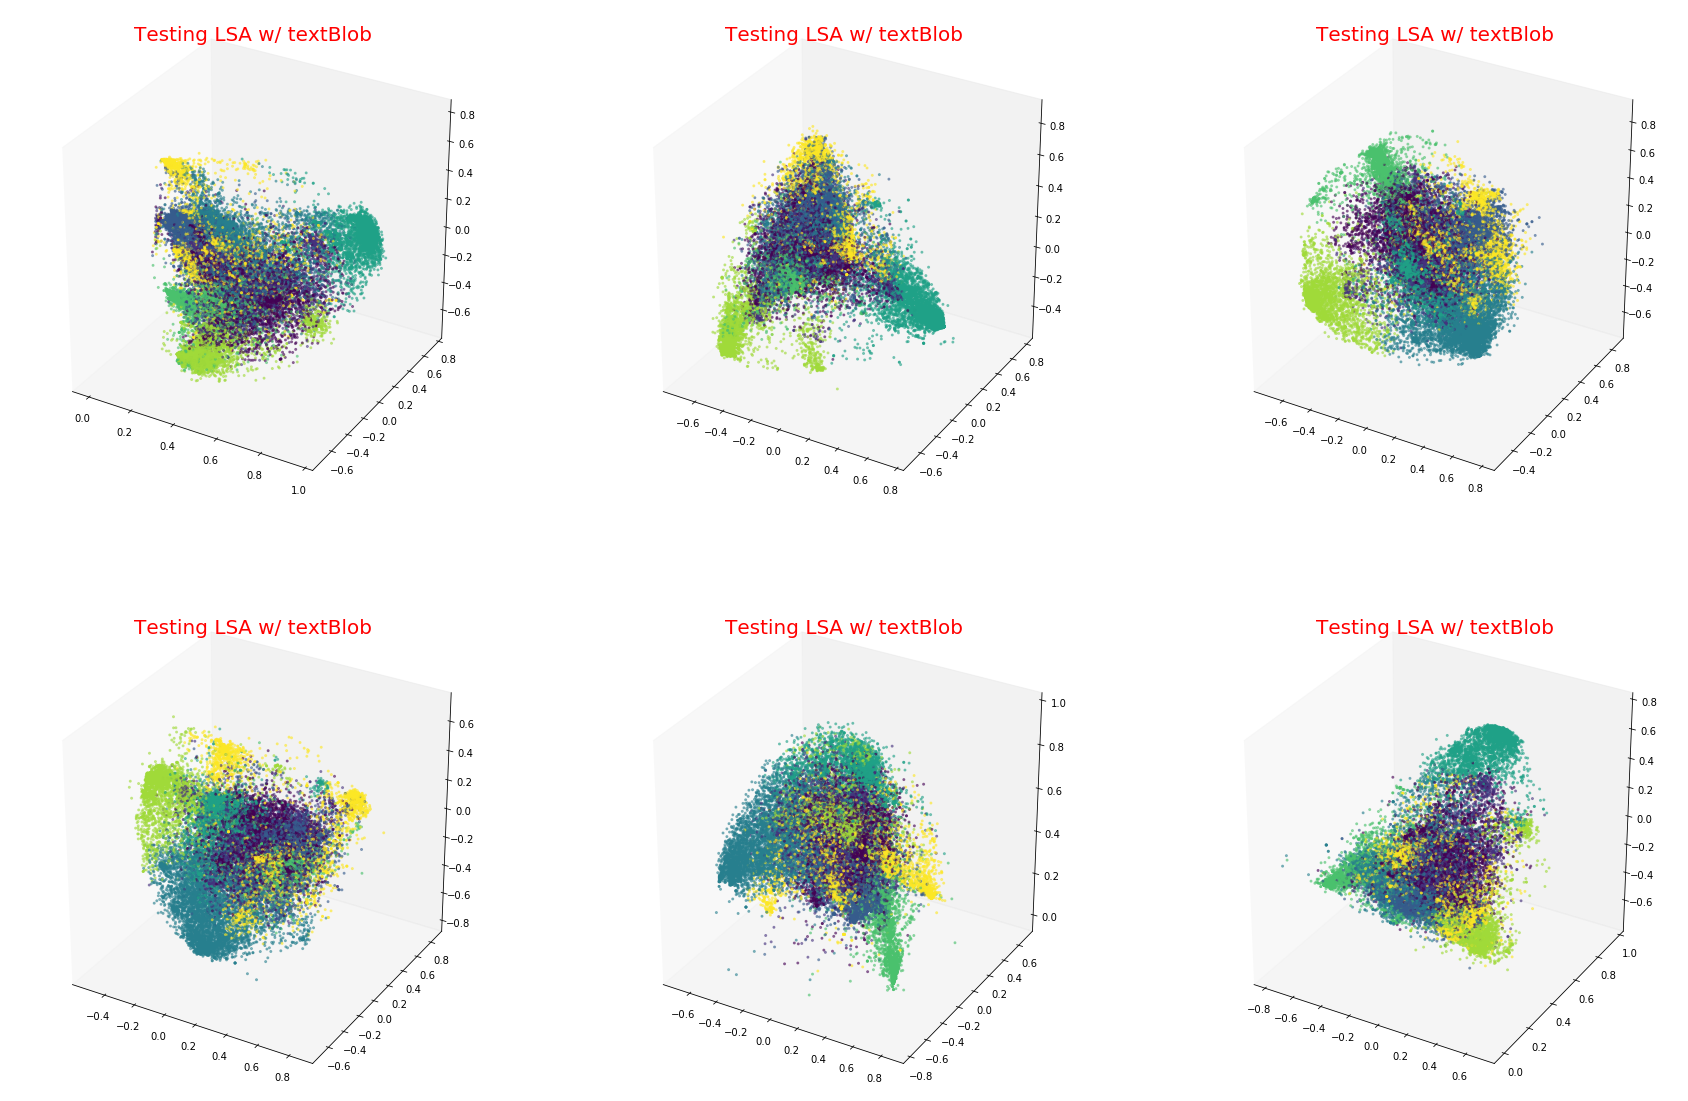

In [37]:
new_kmeans = KMeans(n_clusters=8, random_state=30)
new_kmeans.fit(data_norm)
new_labels = new_kmeans.labels_
plot_all_dimensions3D(data_norm[:,0:6], new_labels, titles="Testing LSA w/ textBlob")

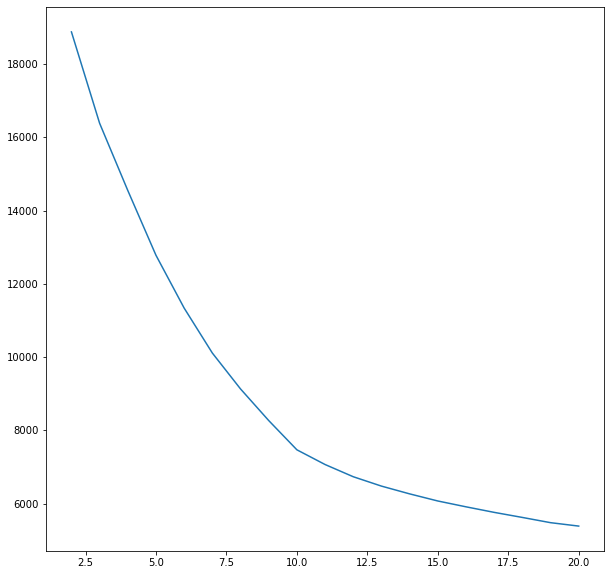

In [36]:
title_kmeans = []
for k in range(2, 21):
    new_kmeans = KMeans(n_clusters=k, random_state=30)
    new_kmeans.fit(data_norm)
    title_kmeans.append([k, new_kmeans.inertia_])
plt.rcParams['figure.figsize'] = [10, 10]
plt.plot(np.array(title_kmeans)[:,0], np.array(title_kmeans)[:,1])

In [43]:
data['title'].to_csv("../model/tempDF.csv")

//anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  """Entry point for launching an IPython kernel.


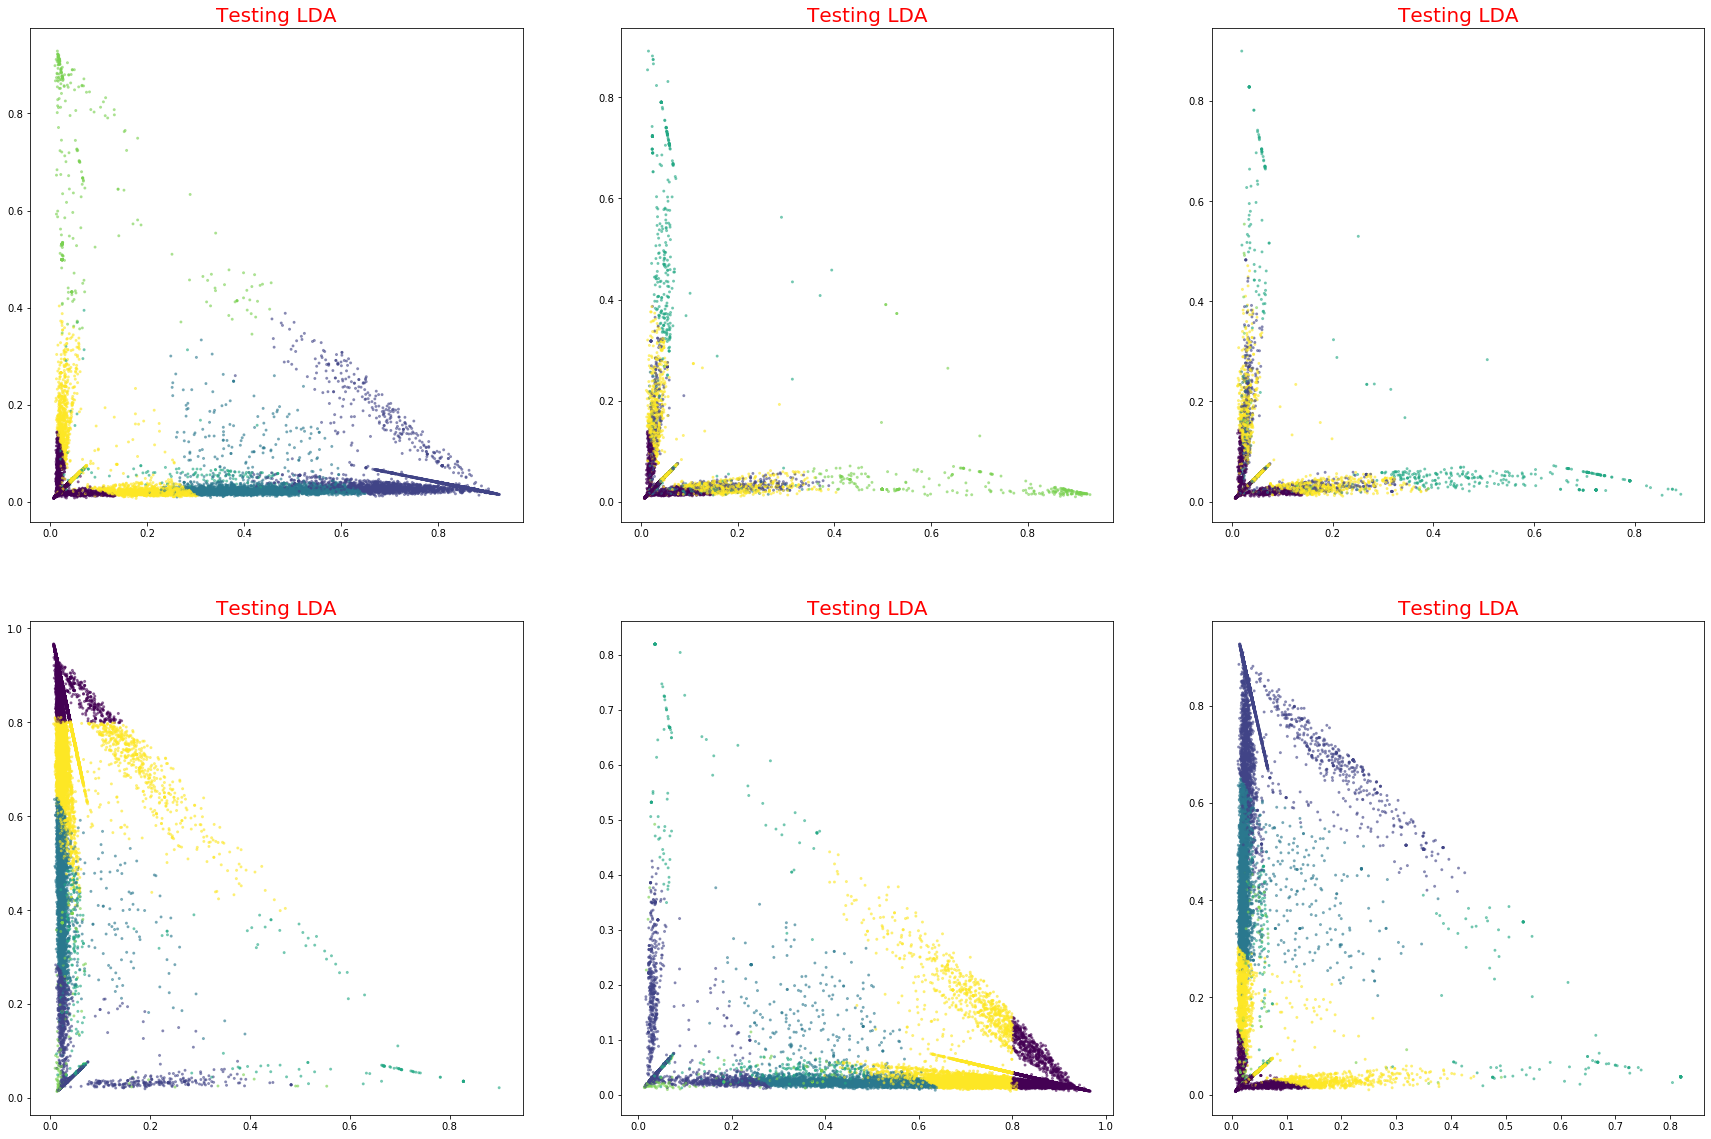

In [8]:
dataDesc=data[data['use_these']==1]['desc_clean']
ckbks_model_lda = nlp_model(vect_method = "tfidf", dim_reduc="LDA", n_components = 6)
ckbks_model_lda.fit(dataDesc)
data_dr_lda = ckbks_model_lda.outputs['Dimensionality Reduction']
labels_lda = ckbks_model_lda.outputs['Clustering']
plot_all_dimensions(data_dr_lda, labels_lda, title="Testing LDA")

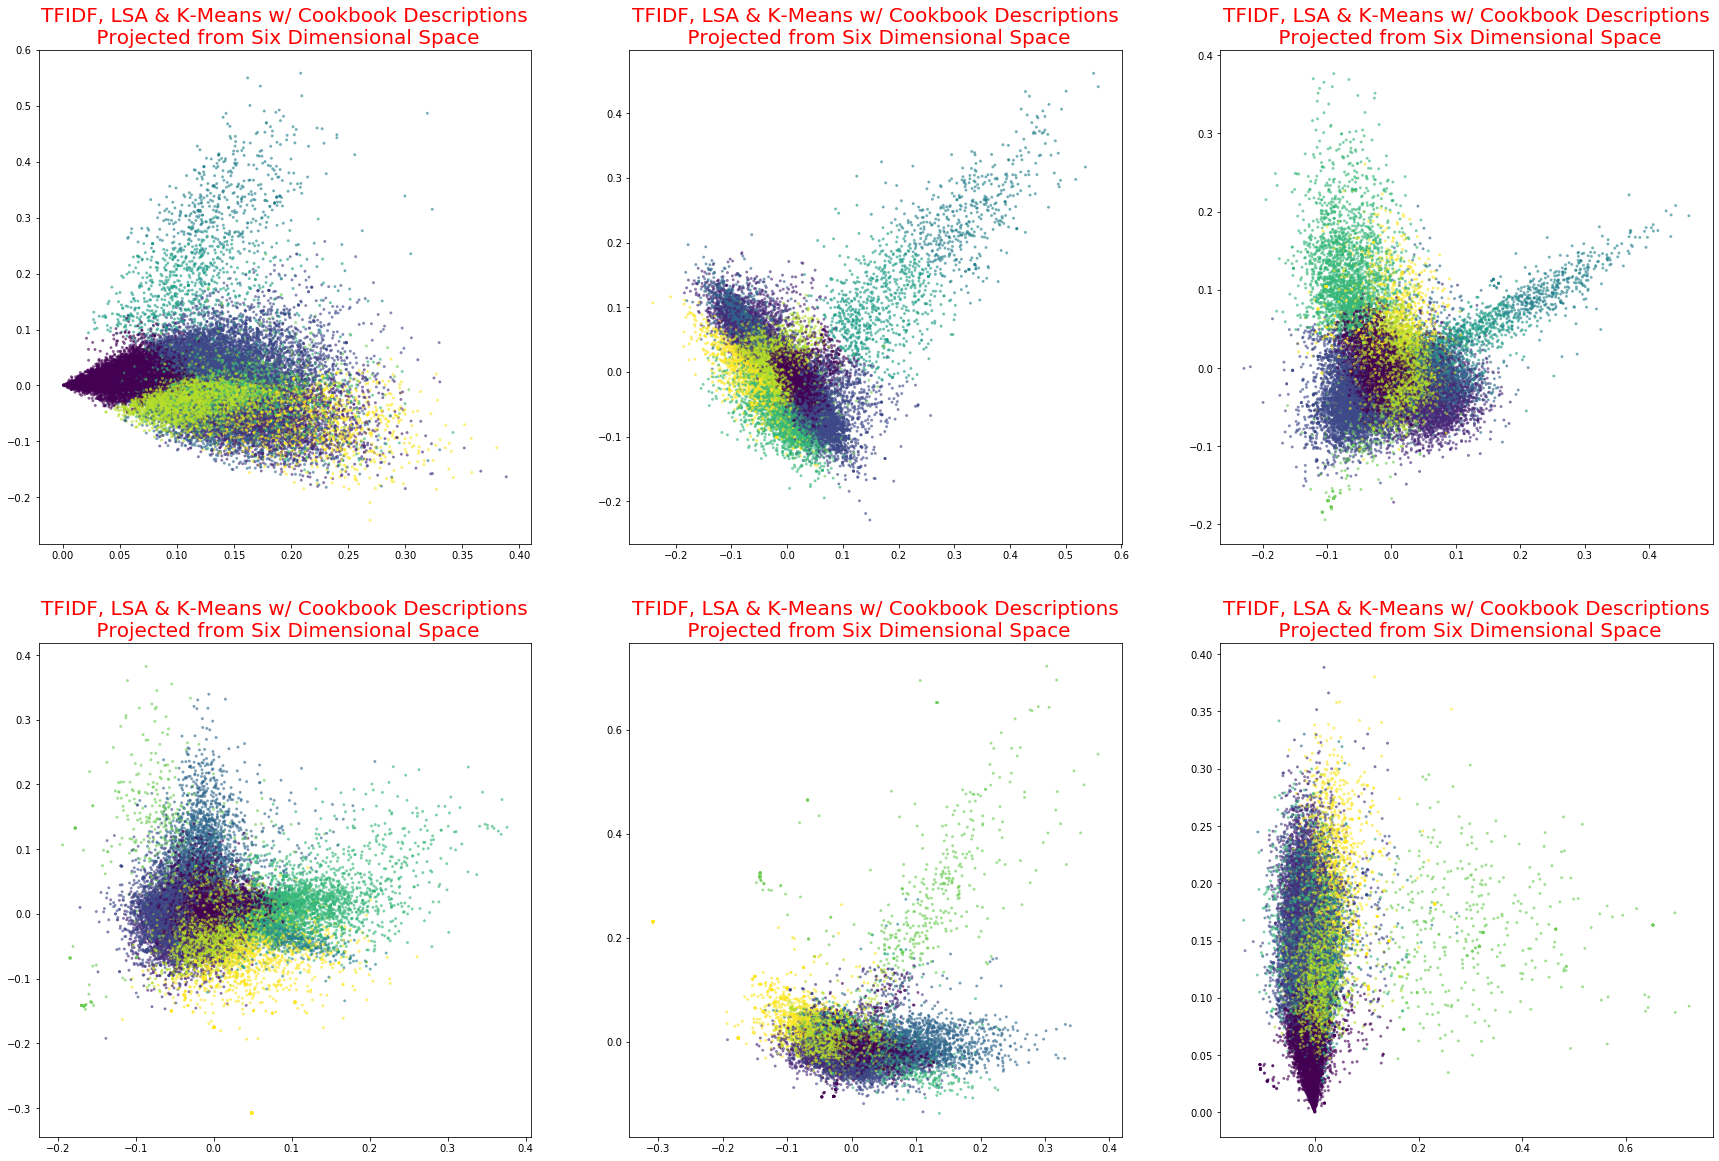

In [109]:
kmeans = KMeans(n_clusters=10, random_state=30).fit(dr_data_desc)
kmeans_tfidf_lsa6 = kmeans.labels_

plot_all_dimensions(dr_data_desc, kmeans_tfidf_lsa6, "TFIDF, LSA & K-Means w/ Cookbook Descriptions\n Projected from Six Dimensional Space")

In [111]:
from sklearn import manifold
tsne_model = manifold.TSNE(n_components=2, init='pca', random_state=0)
tsne_desc_tfidf_lsa6 = tsne_model.fit_transform(dr_data_desc)

In [9]:
vect_methods = ["count", "tfidf"]
dim_reduc = ["PCA", "LSA", "NMF", "LDA"]

ckbk_space = {}

for vect in vect_methods:
    ckbk_space[vect]={}
    for dr in dim_reduc[:-1]:
        print(f"Running NLP on cookbooks using {vect} token vectorization and {dr} dimensionality reduction...")
        model = nlp_model(vect_method = vect, dim_reduc=dr, n_components = 2)
        model.fit(data['title_clean'])
        ckbk_space[vect][dr] = model.doc_dr_data


Running NLP on cookbooks using count token vectorization and PCA dimensionality reduction...
Running NLP on cookbooks using count token vectorization and LSA dimensionality reduction...
Running NLP on cookbooks using count token vectorization and NMF dimensionality reduction...
Running NLP on cookbooks using tfidf token vectorization and PCA dimensionality reduction...
Running NLP on cookbooks using tfidf token vectorization and LSA dimensionality reduction...
Running NLP on cookbooks using tfidf token vectorization and NMF dimensionality reduction...
